# File Information

Name: Amie Davis

Course: DSC680 - Applied Data Science

Project: College Recommendation Engine

Purpose: Build model(s)

Usage: Python 3.7.6

   Developed using Jupter Notebook 6.0.3

# Data Source

College Scorecard is managed by the US Department of Education and provides results such as costs and graduation rates.  
College Scorecard. (n.d.). Retrieved March 15, 2021, from https://collegescorecard.ed.gov/

# References

Albon, C. (2018). Machine learning with Python cookbook: practical solutions from preprocessing to deep learning. O'Reilly.

https://towardsdatascience.com/build-your-own-clustering-based-recommendation-engine-in-15-minutes-bdddd591d394

# Part 3

In Part 3, I will build a k-Means clustering model to perform unsupervised learning to group similar colleges.

## Import required packages

In [1]:
# Suppress Warnings
#import warnings
#warnings.filterwarnings('ignore') 

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle

# Prepare Data

In [2]:
# Load data into dataframe
data_file = "Data\Scorecard\Cleaned_Scorecard.csv" 
df = pd.read_csv(data_file)

## Eliminate non-numeric features

In [3]:
print(df.dtypes)

Unnamed: 0                     int64
UNITID                         int64
SAT_AVG                        int64
ACT_MEDIAN                     int64
TUITION_OUT_ST                 int64
LOCALE                         int64
LATITUDE                     float64
LONGITUDE                    float64
ADM_RATE_ALL                 float64
SIZE                           int64
ONLINE_ONLY                    int64
Y4_COMPLETION_RT             float64
PT_RETENTION_RT              float64
UG_INCOMP_1Y_REPAY_RT        float64
UG_GRAD_4Y_REPAY_RT          float64
UG_PLUS_1Y_REPAY_RT          float64
Y4_COMPLETION_RT_POOLED      float64
FED_LN_AWD_RT                float64
Y5_UG_REPAY_RT               float64
Y5_PLUS_LN_REPAY_RT          float64
DBRR10_FED_UG_RT             float64
DBRR10_PP_UG_RT              float64
OPEID                          int64
OPEID6                         int64
SCHOOL_NAME                   object
CITY                          object
STABBR                        object
Z

In [4]:
# Keep only numeric fields
train_df = df.select_dtypes(include=[np.number])

train_df.head()

,Unnamed: 0,UNITID,SAT_AVG,ACT_MEDIAN,TUITION_OUT_ST,LOCALE,LATITUDE,LONGITUDE,ADM_RATE_ALL,SIZE,...,MEDIAN_DEBT,MEDIAN_PLUS_LN_DEBT,MEDIAN_PLUS_LN_DEBT_GRADS,Y2_LN_DEFAULT_RT,Y2_LN_DELINQ_RT,FED_UG_PAIDINFULL,UG_GRAD_2Y_FORBEAR_RT,LPSTAFFORD_CNT,NUM_STU_PLUS_LN_BAL,LPPPLUS_AMT
0,1,100654,957,18,18354,12,34.783368,-86.568502,0.8986,4990,...,3606.0,14838,16106.0,0.172640,0.074776,0.007926,0.266409,31374.0,5201,113949554.0
1,2,100663,1220,25,19704,12,33.505697,-86.799345,0.9211,13186,...,7504.0,16145,16954.0,0.060389,0.034483,0.059675,0.156121,56997.0,3727,87421879.0
2,3,100690,0,0,6900,12,32.362609,-86.174010,1.0000,351,...,514.0,0,NaN,0.157191,0.050167,NaN,0.000000,4463.0,16,309618.0
3,4,100706,1314,28,22362,12,34.724557,-86.640449,0.8087,7458,...,3021.0,13524,16550.0,0.055035,0.031390,0.092947,0.100349,19702.0,1397,29789762.0
4,5,100724,972,18,19396,12,32.364317,-86.295677,0.9774,3903,...,3609.0,15351,18952.0,0.173804,0.061713,0.007872,0.286976,34246.0,4602,95359062.0


In [5]:
# Find null records
count_nan_in_df = train_df.isnull().sum()
print (count_nan_in_df)

Unnamed: 0                     0
UNITID                         0
SAT_AVG                        0
ACT_MEDIAN                     0
TUITION_OUT_ST                 0
LOCALE                         0
LATITUDE                       0
LONGITUDE                      0
ADM_RATE_ALL                   0
SIZE                           0
ONLINE_ONLY                    0
Y4_COMPLETION_RT               0
PT_RETENTION_RT                0
UG_INCOMP_1Y_REPAY_RT          0
UG_GRAD_4Y_REPAY_RT            0
UG_PLUS_1Y_REPAY_RT            0
Y4_COMPLETION_RT_POOLED        0
FED_LN_AWD_RT                  0
Y5_UG_REPAY_RT                 0
Y5_PLUS_LN_REPAY_RT            0
DBRR10_FED_UG_RT             207
DBRR10_PP_UG_RT              362
OPEID                          0
OPEID6                         0
MAIN_CAMPUS                    0
NUM_BRANCH                     0
OWNERSHIP                      0
ST_FIPS                        0
REGION                         0
NPT41_PRIV                   226
PVT_INCOME

In [6]:
# Handle null Values

# Set null rate data to 0
train_df["DBRR10_FED_UG_RT"].fillna(0, inplace = True)
train_df["DBRR10_PP_UG_RT"].fillna(0, inplace = True)

# Set null monetary data to 0
train_df["FED_UG_PAIDINFULL"].fillna(0, inplace = True)
train_df["LPPPLUS_AMT"].fillna(0, inplace = True)
train_df["PVT_INCOME_30_40K"].fillna(0, inplace = True)

# Impute null median data to median of values in other records
train_df['MEDIAN_DEBT'].fillna(train_df['MEDIAN_DEBT'].median(), inplace=True)
train_df['MEDIAN_PLUS_LN_DEBT_GRADS'].fillna(train_df['MEDIAN_PLUS_LN_DEBT_GRADS'].median(), inplace=True)               

# Some schools have no students with reported income < $30
# Set cost to 0 from NA
train_df["NPT41_PRIV"].fillna(0, inplace = True)
train_df["LPSTAFFORD_CNT"].fillna(0, inplace = True)

C:\Users\amomu\Anaconda3\lib\site-packages\pandas\core\series.py:4469: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [7]:
# Check null records
count_nan_in_df = train_df.isnull().sum()
print (count_nan_in_df)

Unnamed: 0                   0
UNITID                       0
SAT_AVG                      0
ACT_MEDIAN                   0
TUITION_OUT_ST               0
LOCALE                       0
LATITUDE                     0
LONGITUDE                    0
ADM_RATE_ALL                 0
SIZE                         0
ONLINE_ONLY                  0
Y4_COMPLETION_RT             0
PT_RETENTION_RT              0
UG_INCOMP_1Y_REPAY_RT        0
UG_GRAD_4Y_REPAY_RT          0
UG_PLUS_1Y_REPAY_RT          0
Y4_COMPLETION_RT_POOLED      0
FED_LN_AWD_RT                0
Y5_UG_REPAY_RT               0
Y5_PLUS_LN_REPAY_RT          0
DBRR10_FED_UG_RT             0
DBRR10_PP_UG_RT              0
OPEID                        0
OPEID6                       0
MAIN_CAMPUS                  0
NUM_BRANCH                   0
OWNERSHIP                    0
ST_FIPS                      0
REGION                       0
NPT41_PRIV                   0
PVT_INCOME_30_40K            0
TUITION_IN_ST                0
INSTR_EX

## Standardization

In [8]:
# Standardize features into array
scaler = StandardScaler()
features_std = scaler.fit_transform(train_df)

features_std

array([[-1.73120939, -1.1602827 ,  0.45343115, ..., -0.08513354,
         0.70559181,  0.30577287],
       [-1.72952616, -1.16019784,  0.91757109, ...,  0.08830825,
         0.35705198,  0.13645898],
       [-1.72784292, -1.15994327, -1.23547352, ..., -0.26729379,
        -0.5204455 , -0.41953831],
       ...,
       [ 1.72784292,  2.53671497, -1.23547352, ...,  0.37345189,
         0.03097572, -0.06963586],
       [ 1.72952616,  2.53711097, -1.23547352, ..., -0.19134574,
        -0.35705267, -0.29983386],
       [ 1.73120939,  2.53862898, -1.23547352, ..., -0.11424696,
        -0.27121824, -0.27673791]])

# Model Creation and Evaluation

## Build Model

In [9]:
# Use Elbow Method to determine best value for k

# Calculates Within-Cluster-Sum of Squared Errors for k from 1 to kmax
def calculate_WSS(points, kmax):
    
  # Initiate list
  sse = []
    
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # Calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2

    # Return pairs of k and WWS so they can be plotted
    sse_tup = (k,curr_sse)
    sse.append(sse_tup)
    
  return sse

# Test output
calculate_WSS(features_std, 10)

[(1, 4115.999999999996),
 (2, 3059.4212503151994),
 (3, 3644.599246722471),
 (4, 2845.5805426818197),
 (5, 2935.4186427435056),
 (6, 3043.9849555606074),
 (7, 2882.408960006184),
 (8, 2849.207259898587),
 (9, 2784.8486009196317),
 (10, 2766.7883661519377)]

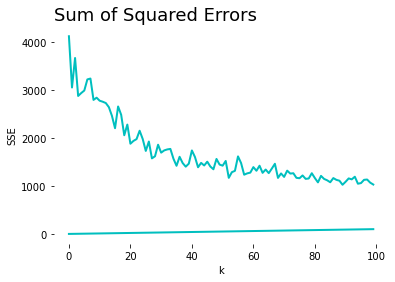

In [31]:
# Plot Elbow Curve (WSS vs. k)
#fig, ax = plt.subplots()  # Create a figure containing a single axes.
# Setup figure w/o axes lines
plt.figure()
plt.axes(frameon=False)

# Plot data
plt.plot(calculate_WSS(features_std, 100), color='c', linewidth=2.0)


# Set plot parameters
plt.title('Sum of Squared Errors', loc='left', fontsize=18)
plt.xlabel('k')
plt.ylabel('SSE')

# Save plot to file
plt.savefig('Elbow_Curve.png', bbox_inches='tight')

# Show Plot
plt.show()

In [11]:
# Create k-Means model
# Selecting k=30 based on the 
cluster = KMeans(n_clusters=30, random_state=0, n_jobs=-1)

In [12]:
# Train model
kmeans = cluster.fit(features_std)

C:\Users\amomu\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:793: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  " removed in 1.0 (renaming of 0.25).", FutureWarning)


In [13]:
# Save machine learning model
filename = 'kmeans_model.sav'
pickle.dump(kmeans, open(filename, 'wb'))

### Model Evaluation

In [14]:
# Vew centroid values
print(kmeans.cluster_centers_)

[[ 1.51593222  2.2711597  -1.23547352 ...  9.37611862  1.51617153
   0.32900296]
 [-0.87711334 -0.64054999  0.51630695 ... -0.23810965 -0.34628419
  -0.30935792]
 [ 0.52452695 -0.02651169  0.52852398 ... -0.239954   -0.30940496
  -0.27394961]
 ...
 [ 1.26425136  1.25232638 -1.23547352 ... -0.28551027 -0.52422883
  -0.42151446]
 [-0.2491191  -0.08656262 -1.23547352 ... -0.26012566 -0.48678957
  -0.39182638]
 [-0.45663128 -0.47645366 -1.17628204 ... -0.18575183 -0.39311939
  -0.3611353 ]]


In [15]:
# View cluster label
kmeans.labels_

array([21,  5, 10, ..., 19, 14, 21])

# Model Deployment

In [16]:
# Function gets the cluster of a school
def cluster_predict(unit_id):
    
    # Find record in clean numeric df
    record_df = train_df.loc[train_df['UNITID'] == unit_id]
    
    # Standardize into array
    std_array = scaler.fit_transform(record_df)
    
    # Assign cluster for specific school
    prediction = kmeans.predict(std_array)
    return prediction

# Test function
# print(cluster_predict(100654))

In [17]:
# Store cluster labels for each school into original df

# Create new column
df['CLUSTERLABEL'] = ""

# Assign cluster label for each school
df['CLUSTERLABEL']=df.apply(lambda x: cluster_predict(df['UNITID']), axis=0)

df.head()

,Unnamed: 0,UNITID,SAT_AVG,ACT_MEDIAN,TUITION_OUT_ST,LOCALE,LATITUDE,LONGITUDE,ADM_RATE_ALL,SIZE,...,MEDIAN_PLUS_LN_DEBT_GRADS,Y2_LN_DEFAULT_RT,Y2_LN_DELINQ_RT,FED_UG_PAIDINFULL,UG_GRAD_2Y_FORBEAR_RT,LPSTAFFORD_CNT,NUM_STU_PLUS_LN_BAL,LPPPLUS_AMT,FED_SCHOOL_CD,CLUSTERLABEL
0,1,100654,957,18,18354,12,34.783368,-86.568502,0.8986,4990,...,16106.0,0.172640,0.074776,0.007926,0.266409,31374.0,5201,113949554.0,001002,21
1,2,100663,1220,25,19704,12,33.505697,-86.799345,0.9211,13186,...,16954.0,0.060389,0.034483,0.059675,0.156121,56997.0,3727,87421879.0,001052,5
2,3,100690,0,0,6900,12,32.362609,-86.174010,1.0000,351,...,NaN,0.157191,0.050167,NaN,0.000000,4463.0,16,309618.0,016885,10
3,4,100706,1314,28,22362,12,34.724557,-86.640449,0.8087,7458,...,16550.0,0.055035,0.031390,0.092947,0.100349,19702.0,1397,29789762.0,001055,5
4,5,100724,972,18,19396,12,32.364317,-86.295677,0.9774,3903,...,18952.0,0.173804,0.061713,0.007872,0.286976,34246.0,4602,95359062.0,001005,21


In [18]:
# Function returns cluister label given a school id
def get_label(unit_id):
    
    rslt_df = df[df['UNITID'] == int(unit_id)]
    cluster_label = rslt_df.CLUSTERLABEL.iloc[0]
    
    return cluster_label

# Test function
# print('CLUSTER LABEL is: ', get_label(100706))

In [19]:
# Function returns school name given a unique school identifier
def get_school_name(unit_id):
    
    rslt_df = df[df['UNITID'] == int(unit_id)]
    
    school_name = rslt_df.SCHOOL_NAME.iloc[0]
    
    return school_name

# Test function
# print('SCHOOL NAME is: ', get_school_name(100706))

In [20]:
# Given a unique school id, return a list of recommended schools in the same cluster
# Note: To find recommendations for Penn State, use UNITID = 214777
unit_id = input('What is the school id of a college which interests you? ')

# Get cluster label for selected school
cluster_label = get_label(int(unit_id))

# Return school_names for all schools in the cluster
rslt_df = df[df['CLUSTERLABEL'] == cluster_label]


# Print output of recommendations
pd.options.display.max_rows = 3000
print('Since you like', get_school_name(unit_id), ', then you might also be interested in these other schools.')
rslt_df.SCHOOL_NAME


What is the school id of a college which interests you? 214777
Since you like Pennsylvania State University-Main Campus , then you might also be interested in these other schools.


1308    Pennsylvania State University-Penn State Erie-...
1309    Pennsylvania State University-Penn State New K...
1310    Pennsylvania State University-Penn State Shenango
1311    Pennsylvania State University-Penn State Wilke...
1312    Pennsylvania State University-Penn State Scranton
1313    Pennsylvania State University-Penn State Lehig...
1314     Pennsylvania State University-Penn State Altoona
1315      Pennsylvania State University-Penn State Beaver
1316       Pennsylvania State University-Penn State Berks
1317    Pennsylvania State University-Penn State Harri...
1318    Pennsylvania State University-Penn State Brand...
1319    Pennsylvania State University-Penn State Fayet...
1320    Pennsylvania State University-Penn State Hazleton
1321            Pennsylvania State University-Main Campus
1322    Pennsylvania State University-Penn State Great...
1323    Pennsylvania State University-Penn State Mont ...
1324    Pennsylvania State University-Penn State Abington
1325    Pennsy